In [1]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
from sklearn.svm import SVR
from six.moves import urllib
from scipy.stats import randint
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

%matplotlib inline
np.random.seed(42)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("/tmp", fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def display_scores(name_scores):
    data = [[score.mean(), score.std()] for _, score in name_scores]
    columns = [name for name, _ in name_scores]
    return pd.DataFrame(data=np.transpose(data), columns=columns, index=["mean", "std"])

/home/hsiehpinghan/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# reference

<a href="https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb">Chapter 2 – End-to-end Machine Learning project</a>

# 1. Frame the problem and look at the big picture.

## Define the objective in business terms.

forecast the house value.

## How will your solution be used?

practice.

## What are the current solutions/workarounds (if any)?

no.

## How should you frame this problem (supervised/unsupervised, online/offline, etc.)?

supervised / offline.

## How should performance be measured?

square root of mean squared error / mean absolute error.

## Is the performance measure aligned with the business objective?

yes.

## What would be the minimum performance needed to reach the business objective?

no.

## What are comparable problems? Can you reuse experience or tools?

no.

## Is human expertise available?

no.

## How would you solve the problem manually?

no.

## List the assumptions you (or others) have made so far.

historial trend would be the same in the future.

## Verify assumptions if possible.

no.

# 2. Get the data.

## List the data you need and how much you need.

housing data.

## Find and document where you can get that data.

In [2]:
HOUSING_DATA_URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

## Check how much space it will take.

400 KB.

## Check legal obligations, and get authorization if necessary.

ok.

## Get access authorizations.

ok.

## Create a workspace (with enough storage space).

ok.

## Get the data.

In [3]:
tgz_path = os.path.join("/tmp", "housing.tgz")
urllib.request.urlretrieve(HOUSING_DATA_URL, tgz_path)
with tarfile.open(tgz_path) as housing_tgz:
    housing_tgz.extractall(path=os.path.join("/tmp"))

## Convert the data to a format you can easily manipulate (without changing the data itself).

In [4]:
housing = pd.read_csv("/tmp/housing.csv")

## Ensure sensitive information is deleted or protected (e.g., anonymized).

yes.

## Check the size and type of data (time series, sample, geographical, etc.).

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Sample a test set, put it aside, and never look at it (no data snooping!).

In [6]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing = strat_train_set.copy()

# 3. Explore the data to gain insights.

## Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

no.

## Create a Jupyter notebook to keep a record of your data exploration.

yes.

## Study each attribute and its characteristics.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


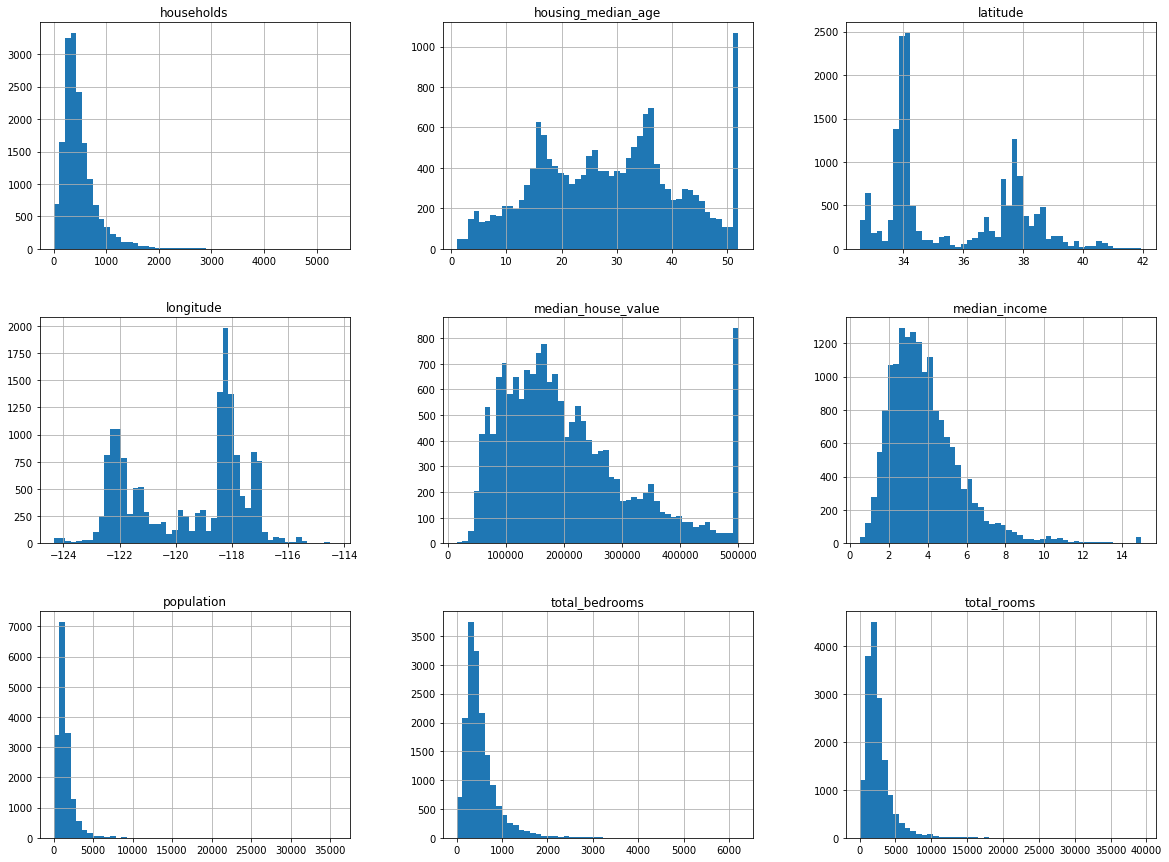

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## For supervised learning tasks, identify the target attribute(s).

median house value.

## Visualize the data.

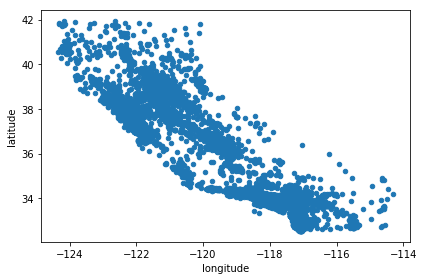

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

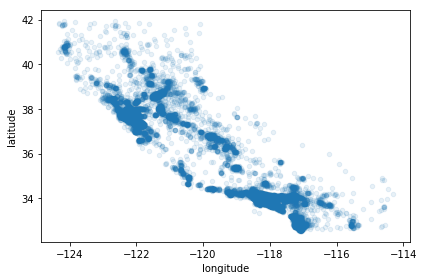

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

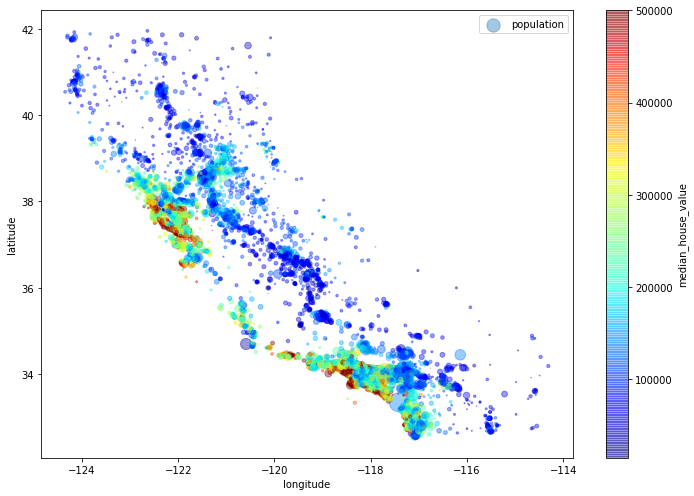

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

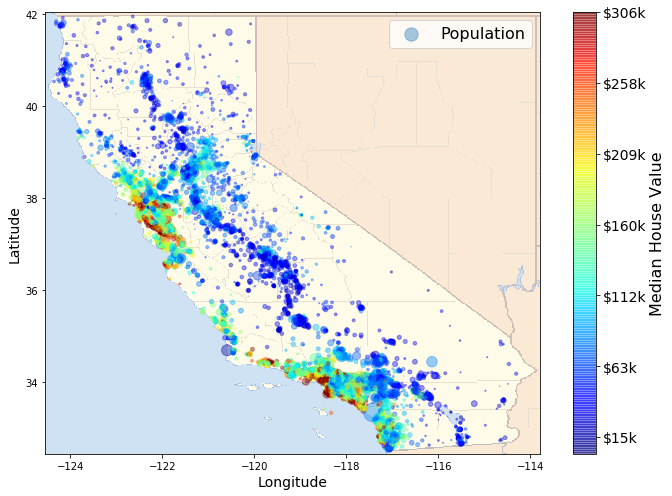

In [12]:
california_img=mpimg.imread("./image/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Study the correlations between attributes.

In [13]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

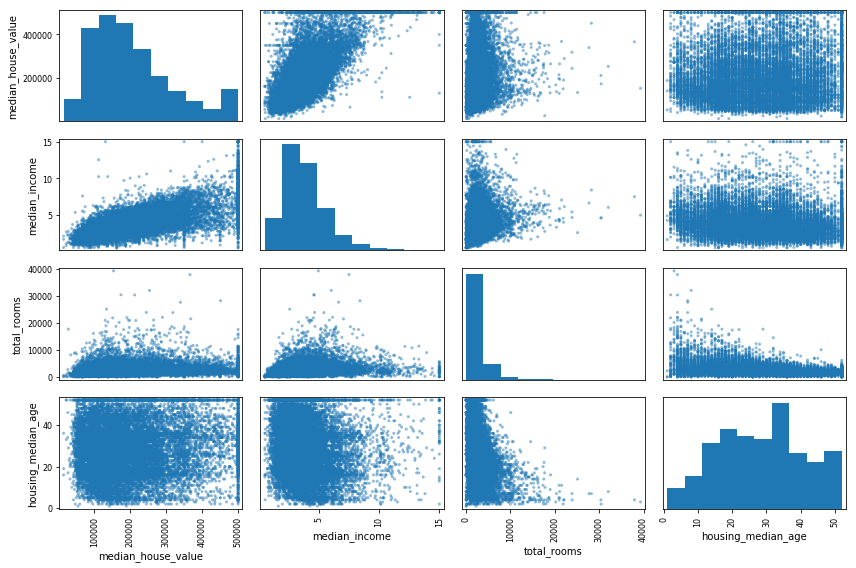

In [14]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

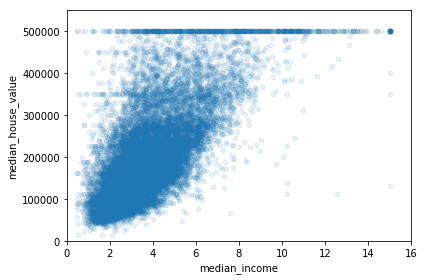

In [15]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Study how you would solve the problem manually.

???

## Identify the promising transformations you may want to apply.

???

## Identify extra data that would be useful.

???

## Document what you have learned.

???

# 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning.

## Feature selection.

## Feature engineering, where appropriate.

## Feature scaling: standardize or normalize features.

In [18]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [19]:
num_attribs = [x for x in list(housing) if x != "ocean_proximity"]
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[0:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

# 5. Explore many different models and short-list the best ones.

##  Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.

## Measure and compare their performance

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)

In [21]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [22]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [23]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)

In [24]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Analyze the most significant variables for each algorithm.

In [25]:
???

Object `` not found.


## Analyze the types of errors the models make.

???

## Have a quick round of feature selection and engineering.

???

## Have one or two more quick iterations of the five previous steps.

???

## Short-list the top three to five most promising models, preferring models that make different types of errors.

???

# 6. Fine-tune your models and combine them into a great solution.

## Fine-tune the hyperparameters using cross-validation.

In [26]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [27]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [28]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [29]:
svr_reg = SVR(kernel="linear")
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

In [30]:
display_scores([("tree_reg", tree_rmse_scores), ("lin_reg", lin_rmse_scores), ("forest_reg", forest_rmse_scores), ("svr_reg", svr_rmse_scores)])

,tree_reg,lin_reg,forest_reg,svr_reg
mean,71379.074477,69052.461363,52564.190252,111809.840096
std,2458.318820,2731.674002,2301.873804,2762.393664


In [31]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [32]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.050440,0.001402,0.003979,0.000284,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.850668e+09,-4.134078e+09,...,-4.051049e+09,1.431223e+08,18,-1.065637e+09,-1.104930e+09,-1.116843e+09,-1.112813e+09,-1.129842e+09,-1.106013e+09,2.173798e+07
1,0.161599,0.002016,0.011678,0.000464,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.052380e+09,-3.250767e+09,...,-3.092639e+09,1.306954e+08,11,-5.932728e+08,-5.871800e+08,-5.780873e+08,-5.713421e+08,-5.797944e+08,-5.819353e+08,7.584886e+06
2,0.483432,0.004207,0.033371,0.000147,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.692176e+09,-3.017478e+09,...,-2.848364e+09,1.604534e+08,9,-4.385337e+08,-4.394786e+08,-4.374429e+08,-4.374715e+08,-4.451903e+08,-4.396234e+08,2.883885e+06
3,0.081127,0.001016,0.003558,0.000087,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.729600e+09,-3.794768e+09,...,-3.716017e+09,1.690029e+08,16,-9.869264e+08,-1.013680e+09,-9.172986e+08,-1.035901e+09,-9.711998e+08,-9.850011e+08,4.047487e+07
4,0.264196,0.001210,0.011627,0.000204,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.667093e+09,-2.786244e+09,...,-2.781569e+09,1.278498e+08,8,-5.100563e+08,-5.158568e+08,-4.960301e+08,-5.422542e+08,-5.158794e+08,-5.160154e+08,1.498960e+07


In [33]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, return_train_score=True)
rnd_search.fit(housing_prepared, housing_labels)
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [34]:
pd.DataFrame(rnd_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.504920,0.031294,0.194387,0.001971,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.275035e+09,-2.475465e+09,-2.557234e+09,...,-2.415443e+09,1.229252e+08,1,-3.380247e+08,-3.291478e+08,-3.299326e+08,-3.406139e+08,-3.370805e+08,-3.349599e+08,4.580675e+06
1,0.473749,0.009441,0.017194,0.000454,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.495492e+09,-2.726653e+09,-2.748356e+09,...,-2.641639e+09,1.155341e+08,9,-4.515641e+08,-4.400704e+08,-4.495595e+08,-4.636103e+08,-4.555627e+08,-4.520734e+08,7.693199e+06
2,1.500822,0.007090,0.078272,0.000746,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.430072e+09,-2.671667e+09,-2.664685e+09,...,-2.580341e+09,1.299596e+08,7,-3.721903e+08,-3.639956e+08,-3.630432e+08,-3.705483e+08,-3.663956e+08,-3.672346e+08,3.586162e+06
3,0.663918,0.005376,0.023941,0.000494,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.428308e+09,-2.685529e+09,-2.685047e+09,...,-2.584781e+09,1.210000e+08,8,-4.169663e+08,-4.092973e+08,-4.092959e+08,-4.210969e+08,-4.141952e+08,-4.141703e+08,4.545366e+06
4,5.080093,0.016644,0.131937,0.000920,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.296127e+09,-2.490273e+09,-2.566137e+09,...,-2.428141e+09,1.186222e+08,2,-3.434716e+08,-3.339827e+08,-3.362798e+08,-3.456355e+08,-3.412989e+08,-3.401337e+08,4.369358e+06


In [35]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

## Try Ensemble methods. Combining your best models will often perform better than running them individually.

???

## Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

In [36]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
m = len(squared_errors)
mean = squared_errors.mean()
np.sqrt(mean)

47766.00396643296

In [37]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45720.21311746024, 49727.70236333663)

In [38]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45720.82652240277, 49727.13838489935)

# 7. Present your solution.

## Document what you have done.

ok.

##  Create a nice presentation.

ok.

## Explain why your solution achieves the business objective.

ok.

## Don’t forget to present interesting points you noticed along the way.

ok.

## Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements.

ok.

# 8. Launch, monitor, and maintain your system.

## Get your solution ready for production.

In [39]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [40]:
prepare_select_and_predict_pipeline = Pipeline([
        ("preparation", full_pipeline),
        ('select', TopFeatureSelector(feature_importances, 10)),
        ("predict", RandomForestRegressor(random_state=42, max_features=8, n_estimators=30))
    ])

prepare_select_and_predict_pipeline.fit(housing, housing_labels)
prepare_select_and_predict_pipeline.predict(strat_test_set.drop("median_house_value", axis=1))

array([486447.43333333, 263096.66666667, 223213.33333333, ...,
       329350.03333333, 176143.33333333, 129993.33333333])

In [42]:
joblib.dump(prepare_select_and_predict_pipeline, "/tmp/full_pipeline_with_predictor.pkl")

['/tmp/full_pipeline_with_predictor.pkl']

## Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.

ok.

## Retrain your models on a regular basis on fresh data.

ok.